## STAT301 2024W2 Group 26 Project 
## Student Number: 23540214
### Loading of Libraries & Dataset

In [1]:
Sys.setLanguage("en")
suppressPackageStartupMessages({
library(haven)    # Loading of .dta, .csv etc. datasets
library(tidyverse)
library(dplyr)
library(datasets)
library(car)
install.packages("vtable")    # maybe needed if not installed
# install.packages("corrplot")  # maybe needed if not installed
# install.packages("sandwich")  # maybe needed if not installed
# install.packages("lmtest")    # maybe needed if not installed
library(vtable)
library(corrplot)
library(sandwich)
library(lmtest)
library(repr)
library(tidymodels)
install.packages("stargazer")      # maybe needed if not installed
library(stargazer)
library(modelr)
library(broom)
library(infer)
library(GGally)
library(leaps)
install.packages("poissonreg")
library(poissonreg)
library(glmnet)
install.packages("coefplot")      # maybe needed if not installed
library(coefplot)
})

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Read the CSV file with specified column types 
market_data <- as_factor(read_delim("https://raw.githubusercontent.com/DrakenRaptor/STAT301_ProjectGrp26/refs/heads/main/marketing_campaign.csv", delim = "\t"))

# Check the structure of data types 
str(market_data)

head(market_data)
str(market_data$Dt_Customer)


Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [2,240 × 29] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ID                 : num [1:2240] 5524 2174 4141 6182 5324 ...
 $ Year_Birth         : num [1:2240] 1957 1954 1965 1984 1981 ...
 $ Education          : chr [1:2240] "Graduation" "Graduation" "Graduation" "Graduation" ...
 $ Marital_Status     : chr [1:2240] "Single" "Single" "Together" "Together" ...
 $ Income             : num [1:2240] 58138 46344 71613 26646 58293 ...
 $ Kidhome            : num [1:2240] 0 1 0 1 1 0 0 1 1 1 ...
 $ Teenhome           : num [1:2240] 0 1 0 0 0 1 1 0 0 1 ...
 $ Dt_Customer        : chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...
 $ Recency            : num [1:2240] 58 38 26 26 94 16 34 32 19 68 ...
 $ MntWines           : num [1:2240] 635 11 426 11 173 520 235 76 14 28 ...
 $ MntFruits          : num [1:2240] 88 1 49 4 43 42 65 10 0 0 ...
 $ MntMeatProducts    : num [1:2240] 546 6 127 20 118 98 164 56 24 6 ...
 $ MntFishProducts    : num [1:2240] 172 2 111 10 46 0 50 3

ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646,1,0,10-02-2014,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,19-01-2014,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513,0,1,09-09-2013,16,520,⋯,6,0,0,0,0,0,0,3,11,0


 chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...


## Introduction & Data Description

The assigned dataset for the project is the Customer Personality Analysis found on In this project, the code below show the descriptive summary of the dataset.

### Data Description

This dataset consists of marketing campaign data for a company, with 2,240 observations and 28 variables. The data captures various attributes about customers, including demographic information, purchase history, and responses to marketing campaigns and purchase history.

| **Variable Name**       | **Type**     | **Description**                                               |
|-------------------------|--------------|---------------------------------------------------------------|
| `ID`                    | Count Data   | Unique identifier for each customer                           |
| `Year_Birth`            | Count Data   | Year of birth of the customer                                 |
| `Education`             | Factor       | Education level of the customer                               |
| `Marital_Status`        | Factor       | Marital status of the customer                                |
| `Income`                | Numeric      | Annual income of the customer                                 |
| `Kidhome`               | Count Data   | Number of children in the customer's household                |
| `Teenhome`              | Count        | Number of teenagers in the customer's household               |
| `Dt_Customer`           | Date\*       | Date of enrollment with the company                           |
| `Recency`               | Count Data   | Days since the last purchase                                  |
| `MntWines`              | Numeric      | Amount spent on wine                                          |
| `MntFruits`             | Numeric      | Amount spent on fruits                                        |
| `MntMeatProducts`       | Numeric      | Amount spent on meat products                                 |
| `MntFishProducts`       | Numeric      | Amount spent on fish products                                 |
| `MntSweetProducts`      | Numeric      | Amount spent on sweet products                                |
| `MntGoldProds`          | Numeric      | Amount spent on gold products                                 |
| `NumDealsPurchases`     | Count Data   | Number of purchases made with a discount                      |
| `NumWebPurchases`       | Count Data   | Number of purchases made through the web                      |
| `NumCatalogPurchases`   | Count Data   | Number of purchases made using a catalog                      |
| `NumStorePurchases`     | Count Data   | Number of purchases made directly in stores                   |
| `NumWebVisitsMonth`     | Count Data   | Number of visits to the company's website in the last month   |
| `AcceptedCmp3`          | Binary       | 1 if the customer accepted the 3rd campaign, 0 otherwise      |
| `AcceptedCmp4`          | Binary       | 1 if the customer accepted the 4th campaign, 0 otherwise      |
| `AcceptedCmp5`          | Binary       | 1 if the customer accepted the 5th campaign, 0 otherwise      |
| `AcceptedCmp1`          | Binary       | 1 if the customer accepted the 1st campaign, 0 otherwise      |
| `AcceptedCmp2`          | Binary       | 1 if the customer accepted the last campaign, 0 otherwise     |
| `Complain`              | Binary       | 1 if the customer has complained in the last 2 years, 0 otherwise |
| `Country`               | Factor       | Country of the customer                                       |


*Given that `Dt_Customer` can be manipulated within the tidyverse library in*
```r 
library(lubridate)
```
*Hence, I have classified it as a `Date` type in the Data Type.*

**Data Source**: The dataset was collected as part of a marketing campaign analysis by Dr. Omar Romero-Hernandez. https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data


## Research Question (Question of Interest)

Customer Personality Analysis is essential to help a firm to modify its product to meet the needs of customers from different segments. In this project, I wish to predict the number of purchases spent made on the web `NumWebPurchases` among customers against the different covariates or predictors such as customer's `Income`, level of education, `NumStorePurchases` , `NumCatalogPurchases`, `NumWebVisitsMonth`, `MntGoldProducts`.

<span style="color: magenta;"> The research question will primarily be focused on prediction. </span>

**<br> Legend:**
- `NumWebPurchases` is the response variable, representing the number of web purchases made through the company's website.
- `Income` is a covariate that indicates the annual earnings of the customer.
- `NumStorePurchases` is a covariate representing the number of purchases made in physical stores.
- `NumCatalogPurchases` is a covariate representing the number of purchases made using a catalog.
- `NumWebVisitsMonth` is a covariate representing the number of visits to the company's website in the last month.
- `MntGoldProds` is a covariate representing the amount spent on gold products.
- `Education` is a covariate that can be represented as a categorical variable.
- `Marital_Status` is a categorical variable that can be represented numerically.
- `NumStorePurchases` is one of the covariates or predictor which represents the number of purchases made in store.
- `Marital_Status` is a categorical variable which can be represented by numerical
- `Education` is one of the covariates which can be represented by a categorical variable.

The code belows shows the unique values present in the `Education` and `Marital_Status` column of the `market_data` data frame. 


In [3]:
unique(market_data$Education)  
unique(market_data$Marital_Status)     # Possible covariates to be used as factor variables for research model, to classify YOLO as single?
market_data_web <- market_data |>
    select(MntGoldProds)

head(market_data_web)
tail(market_data_web)


# Extract the unique values and their counts
education_counts <- table(market_data$Education) 
education_counts


# Extract Unique values of Marital Status
marital_counts <- table(market_data$Marital_Status)
marital_counts


[1] "Graduation" "PhD"        "Master"     "Basic"      "2n Cycle"

[1] "Single"   "Together" "Married"  "Divorced" "Widow"    "Alone"    "Absurd"  
[8] "YOLO"

MntGoldProds
<dbl>
88
6
42
5
15
14


MntGoldProds
<dbl>
9
247
8
24
61
21



  2n Cycle      Basic Graduation     Master        PhD 
       203         54       1127        370        486 


  Absurd    Alone Divorced  Married   Single Together    Widow     YOLO 
       2        3      232      864      480      580       77        2 

### EDA and Visualisation

From the code above, there's seem to be the a huge amount of respondents who possess `2n Cycle` education level. This means that there's a need to include this in the analysis. Since `2n Cycle` is the same as Master's Degree as found in https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/discussion/466400. The code below shows the wrangling tp include them as `Master`. 
A correlation plot maybe suitable to check for the relationship between the continuous random variable such as `Income`, `NumCatalogPurchases`, `NumWebVisitsMonth`, `NumStorePurchases`, `NumWebPurchases`.

A correlation plot maybe suitable to check for the relationship between the continuous random variable such as `Income`, `NumCatalogPurchases`, `NumWebVisitsMonth`, `NumStorePurchases`, `NumWebPurchases`. The correlation plot provides a visual summary of the linear relationship betweem the selected variables. This can help me to see which variables I can include in the regression model for analysation which will be done at a later stage. Additionally, the correlation plot serves as an indicator to check if there's perfect multicolinearity between different variables where an extreme high correlation coefficients (close to -1 or +1) may indicate that.

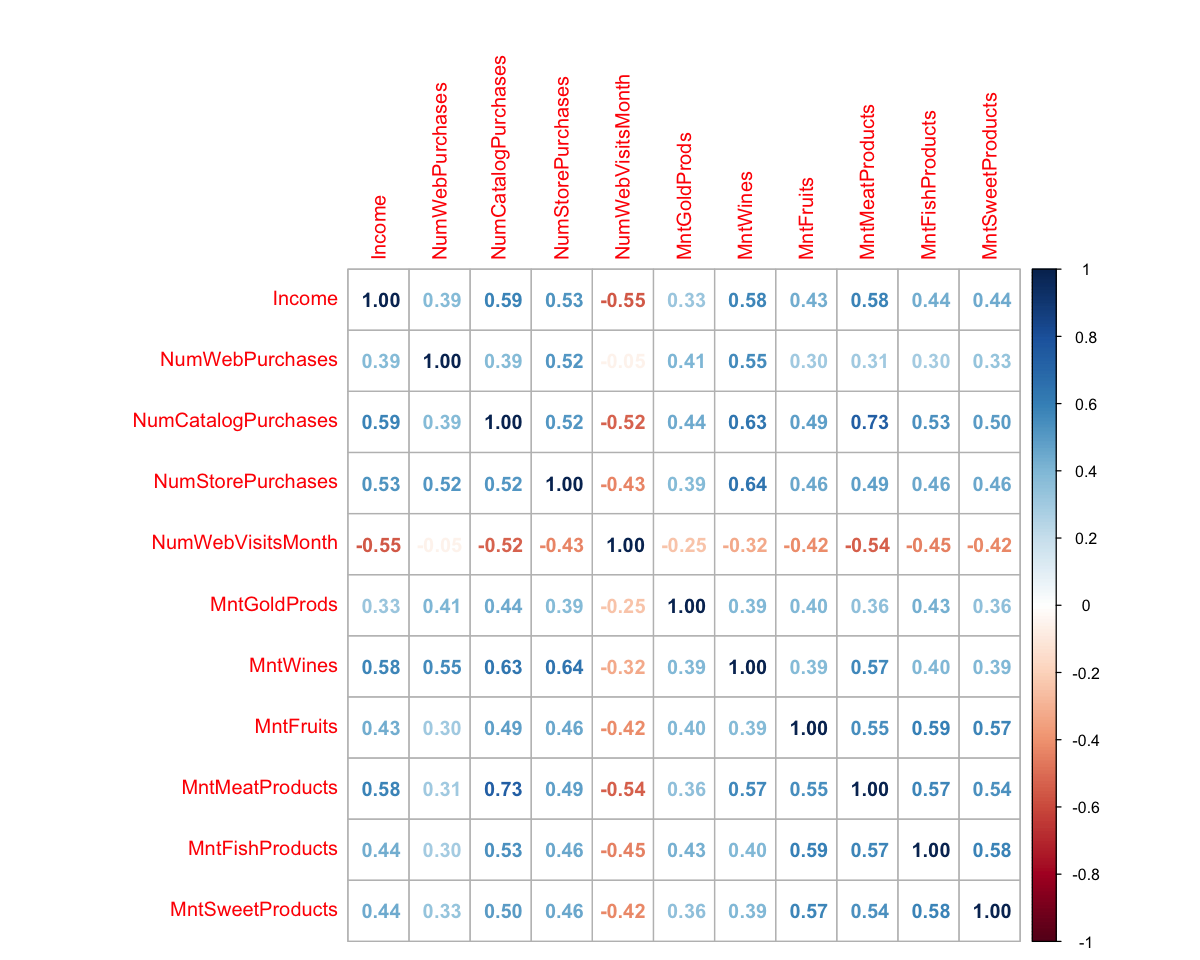

In [4]:
options(repr.plot.width = 10, repr.plot.height = 8)
# Using correlation plot to check the relationship between the variables
corr_plt_dat <- market_data[, c("Income", "NumWebPurchases", "NumCatalogPurchases",
 "NumStorePurchases", "NumWebVisitsMonth", "MntGoldProds", "MntWines", "MntFruits", 
 "MntMeatProducts", "MntFishProducts", "MntSweetProducts")] |>
as.data.frame() 
# Ensure there are no missing values
corr_plt_dat <- na.omit(corr_plt_dat)

cor_matrix <- cor(corr_plt_dat)

# corrplot(cor_matrix, order = "hclust", addrect = 2)
corrplot(cor_matrix, method = "number", addrect = 2)  # To display the correlation values

From the correlation plot, there seems to be a strong positve relationship between `NumCatalogPurchases` and `MntMeatProducts`. This suggests that individuals with higher income tend to make purchases through the Catalogue. Additionally, there's seems to be a weaker (moderate) relationship between `Income` and `NumWebVisitsMonth` which suggests there may be other confounding variables that may influence the number of web purchases and `Income`. Conversely, there's seem to be a moderate-strong negative relationship between `MntMeatProducts` and `NumWebVisitsMonth`.

### Data Wrangling

The code below shows the wrangling of the dataset for the different education level and marital status which will be useful for future analysis for the project.

In [5]:
# Recode '2n Cycle' to 'Master' in the Education column using case_when
market_data <- market_data %>%
    mutate(Education = case_when(
        Education == "2n Cycle" ~ "Master",
        TRUE ~ Education
    ))

# Verify the changes
unique(market_data$Education)

# Recode specific values to 'Single' in the Marital_Status column using case_when
market_data <- market_data %>%
    mutate(Marital_Status = case_when(
        Marital_Status %in% c("Absurd", "Alone", "YOLO", "Together") ~ "Single",
        TRUE ~ Marital_Status
    ))

# Verify the changes
unique(market_data$Marital_Status)

# Convert and Parse Dt_Customer to Date format
market_data$Dt_Customer <- dmy(market_data$Dt_Customer) 
market_data$Dt_Customer

[1] "Graduation" "PhD"        "Master"     "Basic"

[1] "Single"   "Married"  "Divorced" "Widow"

[1] "2012-09-04" "2014-03-08" "2013-08-21" "2014-02-10" "2014-01-19"
   [6] "2013-09-09" "2012-11-13" "2013-05-08" "2013-06-06" "2014-03-13"
  [11] "2013-11-15" "2012-11-13" "2013-11-15" "2013-11-15" "2012-10-10"
  [16] "2012-11-24" "2012-12-24" "2012-08-31" "2013-03-28" "2012-11-03"
  [21] "2012-08-08" "2013-01-06" "2012-12-23" "2014-01-11" "2013-03-18"
  [26] "2013-01-02" "2013-05-27" "2013-02-20" "2013-05-31" "2013-11-22"
  [31] "2014-05-22" "2013-05-11" "2012-10-10" "2012-10-29" "2013-02-20"
  [36] "2013-08-29" "2013-12-31" "2013-09-02" "2014-02-11" "2013-02-01"
  [41] "2013-04-29" "2013-03-12" "2012-12-24" "2013-11-05" "2013-10-02"
  [46] "2014-06-28" "2012-11-09" "2013-05-24" "2014-01-01" "2012-11-08"
  [51] "2014-05-12" "2012-08-11" "2013-01-02" "2014-06-07" "2013-06-12"
  [56] "2012-11-19" "2013-04-02" "2014-04-28" "2013-06-17" "2014-03-03"
  [61] "2013-07-04" "2012-09-07" "2013-02-18" "2013-06-11" "2013-12-06"
  [66] "2013-05-21" "2014-05-11" "2014-03-19" "2013-09-27" "2013-04-08"
  [71] "2012-09-11" "2012-09-14" "2013-03-17" "2013-04-05" "2014-04-30"
  [76] "2012-12-19" "2012-08-27" "2012-10-12" "2013-09-04" "2013-01-02"
  [81] "2012-08-29" "2013-06-23" "2013-07-03" "2013-05-11" "2014-02-25"
  [86] "2013-08-11" "2013-07-16" "2014-05-28" "2014-05-12" "2014-01-21"
  [91] "2012-11-19" "2014-05-27" "2013-11-23" "2014-03-23" "2014-05-24"
  [96] "2014-05-22" "2012-11-22" "2013-04-11" "2013-12-01" "2013-06-20"
 [101] "2013-07-23" "2014-03-30" "2013-04-20" "2013-05-17" "2014-05-08"
 [106] "2013-12-10" "2013-09-24" "2013-02-02" "2012-12-19" "2012-12-07"
 [111] "2013-11-02" "2012-11-10" "2014-06-25" "2013-01-02" "2012-12-12"
 [116] "2013-09-10" "2014-01-24" "2013-02-19" "2013-07-11" "2013-11-14"
 [121] "2013-06-20" "2014-02-24" "2013-09-04" "2013-04-22" "2013-03-12"
 [126] "2013-02-18" "2013-04-21" "2014-06-08" "2013-07-11" "2014-05-10"
 [131] "2013-09-30" "2013-03-10" "2014-02-10" "2013-08-11" "2013-08-14"
 [136] "2013-03-17" "2012-08-08" "2013-07-07" "2014-05-19" "2013-07-28"
 [141] "2012-10-19" "2013-11-14" "2013-04-19" "2013-08-28" "2013-03-19"
 [146] "2012-10-18" "2012-10-28" "2013-08-28" "2012-08-22" "2014-06-21"
 [151] "2014-04-24" "2014-03-07" "2012-12-14" "2014-05-12" "2012-10-09"
 [156] "2013-02-19" "2013-07-08" "2013-09-12" "2013-10-17" "2013-08-20"
 [161] "2013-07-01" "2012-11-05" "2014-01-05" "2013-05-01" "2014-03-01"
 [166] "2013-11-13" "2013-11-18" "2013-08-28" "2013-11-02" "2014-02-25"
 [171] "2014-04-21" "2013-07-13" "2014-04-21" "2014-01-30" "2014-04-04"
 [176] "2012-09-12" "2012-12-16" "2014-05-23" "2014-06-24" "2013-12-01"
 [181] "2014-05-11" "2014-05-10" "2013-09-28" "2014-01-22" "2014-06-15"
 [186] "2012-12-05" "2014-03-08" "2013-08-02" "2013-03-19" "2013-02-23"
 [191] "2012-09-09" "2013-05-17" "2013-09-26" "2013-05-30" "2013-02-18"
 [196] "2013-12-29" "2014-05-13" "2013-09-19" "2013-01-17" "2014-03-31"
 [201] "2014-06-29" "2013-12-09" "2013-10-14" "2012-11-02" "2013-07-17"
 [206] "2012-11-10" "2013-12-08" "2013-05-13" "2014-06-08" "2012-09-10"
 [211] "2013-03-31" "2014-03-18" "2012-10-05" "2013-01-21" "2013-05-04"
 [216] "2014-04-01" "2014-05-12" "2013-11-15" "2013-08-31" "2012-11-14"
 [221] "2014-04-11" "2013-11-14" "2014-04-14" "2013-01-05" "2012-09-08"
 [226] "2013-03-26" "2012-10-25" "2012-12-09" "2012-08-08" "2014-02-16"
 [231] "2013-03-20" "2013-01-05" "2013-05-15" "2014-04-16" "2013-03-23"
 [236] "2013-12-09" "2013-12-04" "2013-10-04" "2013-12-26" "2014-05-17"
 [241] "2013-10-28" "2012-12-23" "2013-07-31" "2013-11-28" "2012-08-17"
 [246] "2014-06-05" "2013-05-20" "2013-01-09" "2012-08-31" "2012-10-29"
 [251] "2013-09-16" "2013-10-27" "2013-04-05" "2012-09-22" "2012-08-29"
 [256] "2012-10-13" "2012-10-16" "2012-10-22" "2013-06-04" "2013-12-08"
 [261] "2012-10-10" "2013-05-22" "2014-06-17" "2012-11-23" "2013-02-03"
 [266] "2013-03-14" "2014-06-26" "2012-10-15" "2013-06-19" "2013-10-04"
 [271] "2012-09-22" "2014-03-20" "2014-02-04" "2014-04-06" "2013-02-06"
 [276] "2013-09-16" "2013-01-17" "2014-04-3

In [6]:
# Cleaned Data
head(market_data)


ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,2012-09-04,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,2014-03-08,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Single,71613,0,0,2013-08-21,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Single,26646,1,0,2014-02-10,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,2014-01-19,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Single,62513,0,1,2013-09-09,16,520,⋯,6,0,0,0,0,0,0,3,11,0


From the cleaned data, the `ID` column is kept where it maybe useful for analysing a particular individual customer spending pattern.

### Methods and Plan

Given that the requirement of the project is to use Poisson Regression. Forward Selection is used to decide if which variables are relevant for analysis.

Since the research question is focused on prediction as mentioned above, there's a need to split the dataset between the testing and training datasets using the `tidymodels` package. The code below shows the splitting of the dataset, where 75% of the data is split as training data and 25% for testing data. 

In [7]:
# Remove rows with missing values
market_data <- na.omit(market_data)
set.seed(5638)

market_data_split <- initial_split(market_data, prop = 0.75, strata = Income)
market_data_train <- training(market_data_split)

market_data_test <- testing(market_data_split)

head(market_data_train)
cat('\nMarket Training Data has', nrow(market_data_train), 'rows.\n')

ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6177,1985,PhD,Married,33454,1,0,2013-05-08,32,76,⋯,8,0,0,0,0,0,0,3,11,0
2569,1987,Graduation,Married,17323,0,0,2012-10-10,38,3,⋯,8,0,0,0,0,0,0,3,11,0
2278,1985,Master,Single,33812,1,0,2012-11-03,86,4,⋯,6,0,0,0,0,0,0,3,11,0
5376,1979,Graduation,Married,2447,1,0,2013-01-06,42,1,⋯,1,0,0,0,0,0,0,3,11,0
10755,1976,Master,Married,23718,1,0,2013-09-02,76,6,⋯,7,0,0,0,0,0,0,3,11,0
2139,1975,Master,Married,7500,1,0,2013-10-02,19,3,⋯,5,0,0,0,0,0,0,3,11,0



Market Training Data has 1660 rows.


In [8]:
cat('\nMarket Testing data has', nrow(market_data_test), 'rows.')


Market Testing data has 556 rows.

In [9]:
# Define the Poisson regression specification
poisson_spec <-
    poisson_reg() %>%
    set_engine("glm") %>%
    set_mode("regression")

# Define the recipe
poisson_recipe <- recipe(NumWebPurchases ~ Income + MntGoldProds 
+ NumCatalogPurchases + NumStorePurchases + NumWebVisitsMonth 
+ MntWines + MntFruits + MntMeatProducts + MntFishProducts 
+ MntSweetProducts, data = market_data_train)

# Create and fit the workflow
poisson_model <-
    workflow() %>%
    add_recipe(poisson_recipe) %>%
    add_model(poisson_spec) %>%
    fit(data = market_data_train)

poisson_coeffs <- poisson_model |>
    extract_fit_parsnip() |>
    tidy()

poisson_coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-7.665227e-03,5.840664e-02,-0.1312390,8.955863e-01
Income,2.764031e-06,4.050723e-07,6.8235510,8.881718e-12
MntGoldProds,1.766394e-03,2.325296e-04,7.5964275,3.044177e-14
NumCatalogPurchases,2.120930e-02,6.481588e-03,3.2722376,1.066998e-03
NumStorePurchases,6.066694e-02,4.763091e-03,12.7368853,3.688279e-37
NumWebVisitsMonth,9.361102e-02,6.343437e-03,14.7571461,2.767460e-49
MntWines,4.472604e-04,4.813298e-05,9.2921820,1.511572e-20
MntFruits,1.622307e-04,3.555620e-04,0.4562655,6.481991e-01
MntMeatProducts,-2.304876e-05,7.996956e-05,-0.2882192,7.731790e-01


### Justification
The code above shows the poisson regression analysis where `NumWebPurchases` is the response variable which represents count data. Poisson regression is specifically designed to model count data which is suitable when the response variable is non-negative integer (e.g. 0, 1, 2...). The method allows us to model the relationship between the count response variable and multiple covariates (e.g. `Income`, `MntGoldProds`, `NumCatalogPurchases` etc.). Although Poisson Regression is good to compare count data, there are still some potential limitations of this method. Overdispersion is **one** potential limitation where the variance of the response variable is greater than the mean, where the regression model may underestimate the standard errors which may lead to invalid statisical inferences. Underdispersion may occur where the variance is less than the mean where the model may not fit well.

However, Poisson regression through prediction is very useful for modelling count data `NumWebPurchases` which allows us to explore the relationship between the response variable and various covariates.

#### Forward Selection in `market_data`

The code below shows the forward selection method to determine which of the input variables could be used as potential covariates and a strong generative model through the use of `regsubsets()` on the training data `market_data`. The size of 28 is chosen for `nvmax` since with the exclusion of the first column `ID` which represents the Customer Unique ID which is not useful for using it as part of the model.

In [18]:
market_foward_sel1 <- regsubsets(NumWebPurchases ~ ., nvmax = 28,
        data = market_data_train, method = "forward")
        
summary(market_foward_sel1)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“2  linear dependencies found”


Reordering variables and trying again:


Subset selection object
Call: regsubsets.formula(NumWebPurchases ~ ., nvmax = 28, data = market_data_train, 
    method = "forward")
32 Variables  (and intercept)
                      Forced in Forced out
ID                        FALSE      FALSE
Year_Birth                FALSE      FALSE
EducationGraduation       FALSE      FALSE
EducationMaster           FALSE      FALSE
EducationPhD              FALSE      FALSE
Marital_StatusMarried     FALSE      FALSE
Marital_StatusSingle      FALSE      FALSE
Marital_StatusWidow       FALSE      FALSE
Income                    FALSE      FALSE
Kidhome                   FALSE      FALSE
Teenhome                  FALSE      FALSE
Dt_Customer               FALSE      FALSE
Recency                   FALSE      FALSE
MntWines                  FALSE      FALSE
MntFruits                 FALSE      FALSE
MntMeatProducts           FALSE      FALSE
MntFishProducts           FALSE      FALSE
MntSweetProducts          FALSE      FALSE
MntGoldProds        

Given that The output above shows that variables are selected one at a time and once the variable is in the model, it stays and the next variable is then selected. The algorithm continues until it bu

The code below shows the Poisson regression where the 

In [11]:
reg1 <- glm(
    NumWebPurchases ~ Income + MntGoldProds + NumCatalogPurchases + 
        NumStorePurchases + NumWebVisitsMonth + MntWines + MntFruits + 
        MntMeatProducts + MntFishProducts + MntSweetProducts, 
    data = market_data_train, 
    family = poisson(link = "log")
)
summary(reg1)


Call:
glm(formula = NumWebPurchases ~ Income + MntGoldProds + NumCatalogPurchases + 
    NumStorePurchases + NumWebVisitsMonth + MntWines + MntFruits + 
    MntMeatProducts + MntFishProducts + MntSweetProducts, family = poisson(link = "log"), 
    data = market_data_train)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -7.665e-03  5.841e-02  -0.131  0.89559    
Income               2.764e-06  4.051e-07   6.824 8.88e-12 ***
MntGoldProds         1.766e-03  2.325e-04   7.596 3.04e-14 ***
NumCatalogPurchases  2.121e-02  6.482e-03   3.272  0.00107 ** 
NumStorePurchases    6.067e-02  4.763e-03  12.737  < 2e-16 ***
NumWebVisitsMonth    9.361e-02  6.343e-03  14.757  < 2e-16 ***
MntWines             4.473e-04  4.813e-05   9.292  < 2e-16 ***
MntFruits            1.622e-04  3.556e-04   0.456  0.64820    
MntMeatProducts     -2.305e-05  7.997e-05  -0.288  0.77318    
MntFishProducts      4.976e-04  2.819e-04   1.766  0.07748 .  
MntSweetProducts 

In [12]:
reg1b <- glm(
	NumWebPurchases ~ Income + NumStorePurchases + NumDealsPurchases + 
	MntSweetProducts + MntGoldProds + MntWines + Education + Kidhome + Teenhome, 
	data = market_data_train, 
	family = poisson(link = "log")
)

summary(reg1b)


Call:
glm(formula = NumWebPurchases ~ Income + NumStorePurchases + 
    NumDealsPurchases + MntSweetProducts + MntGoldProds + MntWines + 
    Education + Kidhome + Teenhome, family = poisson(link = "log"), 
    data = market_data_train)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.916e-01  1.158e-01   3.383 0.000718 ***
Income               1.509e-06  5.184e-07   2.910 0.003610 ** 
NumStorePurchases    3.298e-02  4.845e-03   6.807 9.96e-12 ***
NumDealsPurchases    9.194e-02  6.768e-03  13.584  < 2e-16 ***
MntSweetProducts     9.959e-04  3.143e-04   3.169 0.001532 ** 
MntGoldProds         1.440e-03  2.329e-04   6.182 6.33e-10 ***
MntWines             5.016e-04  4.558e-05  11.004  < 2e-16 ***
EducationGraduation  2.694e-01  1.161e-01   2.321 0.020267 *  
EducationMaster      2.499e-01  1.174e-01   2.129 0.033264 *  
EducationPhD         2.529e-01  1.184e-01   2.136 0.032682 *  
Kidhome             -2.123e-01  3.279e-02  -6.475 9.51

In [13]:
reg1c <- glm(NumWebPurchases ~ Income * Education + NumStorePurchases + NumDealsPurchases + 
	MntSweetProducts + MntGoldProds + MntWines + Kidhome + Teenhome, 
	data = market_data_train, 
	family = poisson
)

summary(reg1c)


Call:
glm(formula = NumWebPurchases ~ Income * Education + NumStorePurchases + 
    NumDealsPurchases + MntSweetProducts + MntGoldProds + MntWines + 
    Kidhome + Teenhome, family = poisson, data = market_data_train)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -3.066e-01  4.127e-01  -0.743   0.4574    
Income                      3.361e-05  1.774e-05   1.895   0.0582 .  
EducationGraduation         9.890e-01  4.136e-01   2.391   0.0168 *  
EducationMaster             9.045e-01  4.190e-01   2.159   0.0309 *  
EducationPhD                8.050e-01  4.224e-01   1.906   0.0567 .  
NumStorePurchases           3.233e-02  4.882e-03   6.623 3.53e-11 ***
NumDealsPurchases           9.253e-02  6.804e-03  13.601  < 2e-16 ***
MntSweetProducts            9.523e-04  3.162e-04   3.012   0.0026 ** 
MntGoldProds                1.478e-03  2.337e-04   6.323 2.56e-10 ***
MntWines                    4.835e-04  4.737e-05  10.206  < 2e-16 

The code below shows the robust standard errors that's used for Poisson regression, where the `vcovHC` function is within the `sandwich` package which is compatible with Generalised Linear Models (GLMs). This calculates the heteroskedasticity consistent robust standard errors for Poisson regression coefficients.

In [14]:
# Extract the fitted model from the workflow
fitted_poisson_model <- poisson_model |>
     extract_fit_parsnip() |>
     pluck("fit")

# Calculate robust covariance matrix
vcov_robust_poisson <- vcovHC(fitted_poisson_model, type = "HC")

# Calculate robust standard errors
robust_se_poisson <- sqrt(diag(vcov_robust_poisson))

robust_se_poisson

# Conduct hypothesis tests with robust standard errors
reg2 <- coeftest(fitted_poisson_model, vcov. = vcov_robust_poisson)

# Conduct hypothesis tests (with robust standard errors)
# reg2 <- coeftest(reg1, vcov. = vcov_robust)

(Intercept)              Income        MntGoldProds NumCatalogPurchases 
       1.087560e-01        1.140774e-06        4.657994e-04        7.983884e-03 
  NumStorePurchases   NumWebVisitsMonth            MntWines           MntFruits 
       5.766454e-03        1.146014e-02        6.011927e-05        3.606172e-04 
    MntMeatProducts     MntFishProducts    MntSweetProducts 
       7.494371e-05        3.026406e-04        3.354190e-04

In [15]:
stargazer_res <- stargazer(reg1, reg1b, reg1c, reg2, title = "Comparison of Multiple Regression Results",
         align = TRUE, type="text", keep =  c(), # Specify predictors to keep 
         digits = 9, keep.stat = c("n","rsq", "aic", "bic"))


Comparison of Multiple Regression Results
                                                Dependent variable:                      
                           --------------------------------------------------------------
                                           NumWebPurchases                                
                                               Poisson                       coefficient  
                                                                                test      
                                 (1)             (2)             (3)            (4)      
-----------------------------------------------------------------------------------------
Income                     0.000002764***  0.000001509***   0.000033607*   0.000002764** 
                            (0.000000405)   (0.000000518)   (0.000017739)  (0.000001141) 
                                                                                         
MntGoldProds               0.001766394***  0.001439652

From the `stargazer` result as shown above, the results indicate that several covariates such as `NumStorePurchases`, `NumCatalogPurchases`, `Income` and `MntGoldProds` which have statistically significant positive effects on the number of web purchases `NumWebPurchases`. The coefficients of these variables suggests that 

The code belows shows the Q-Q plot to check for overdispersions where the variance of the response variable is greater than the mean. Additionally, it also checks for heteroskedasticity where the variance of the residuals may not be constant. 

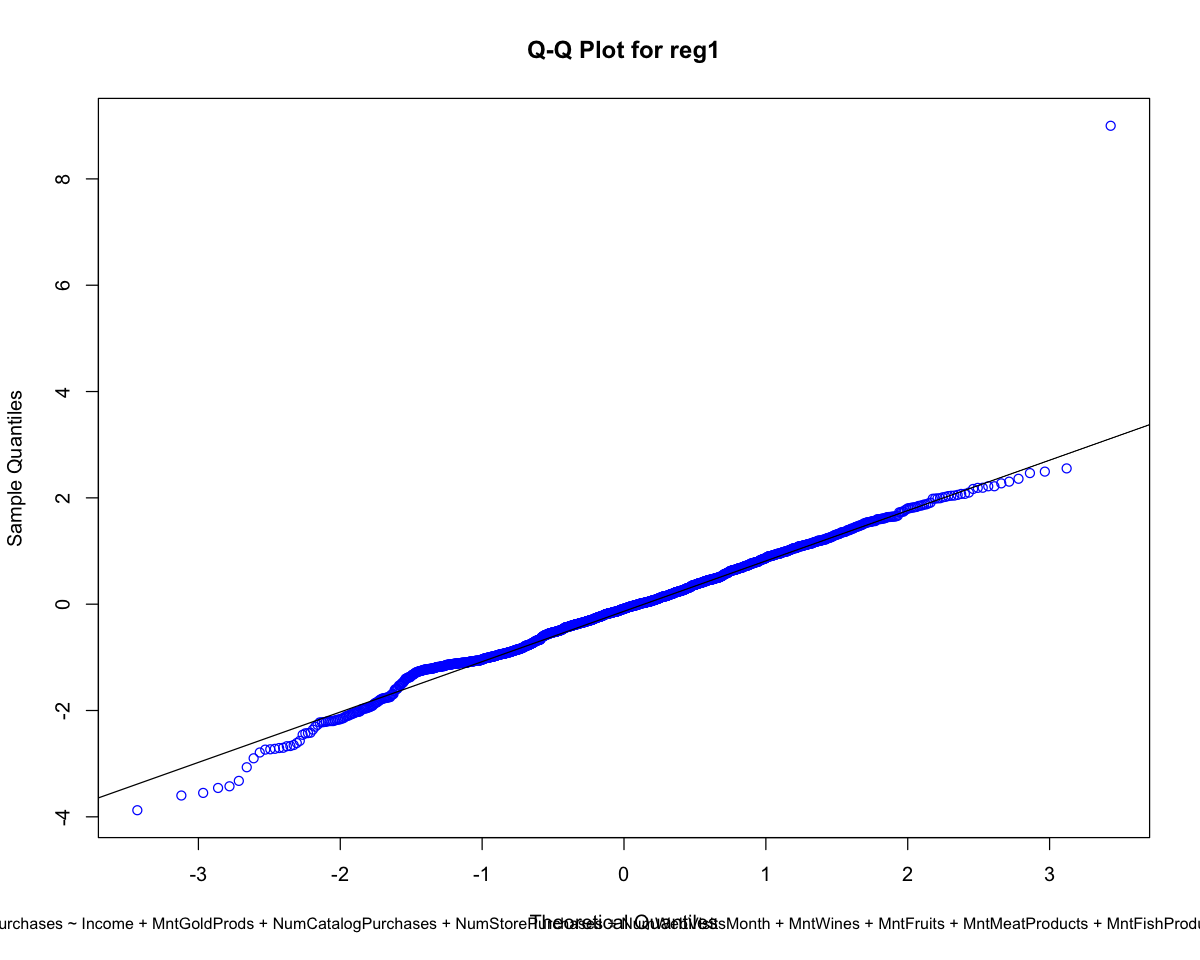

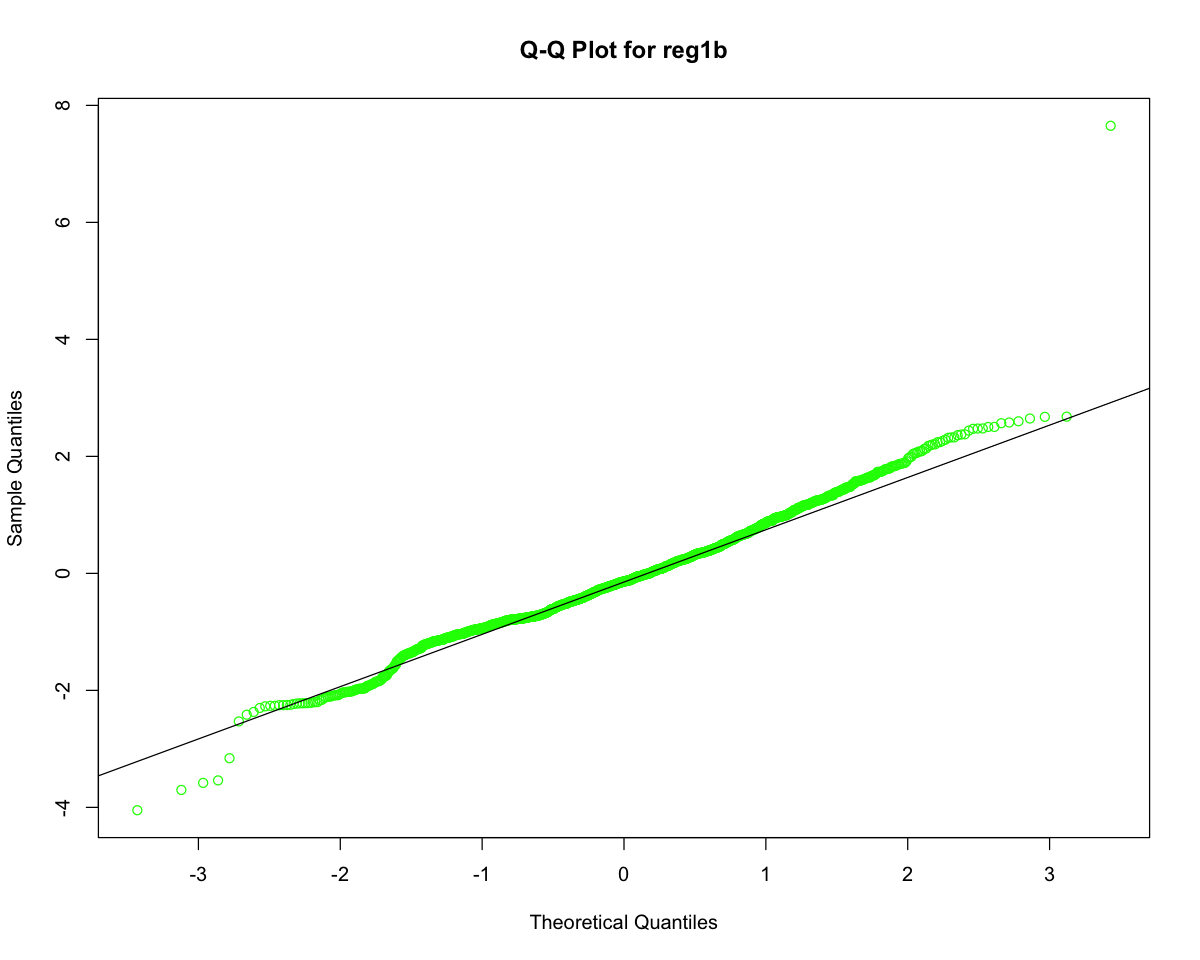

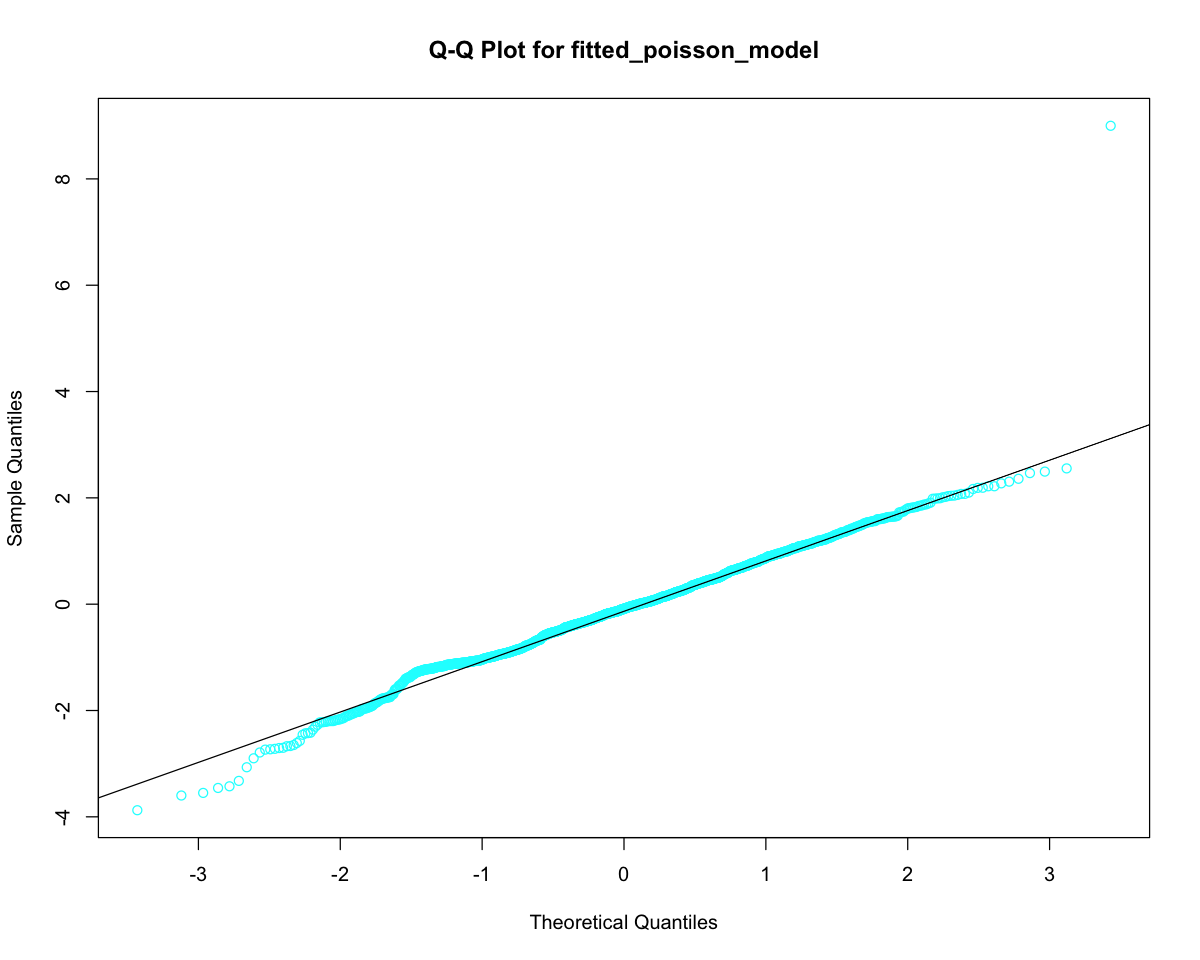

In [16]:
# Q-Q plot for reg1
qqnorm(residuals(reg1, type = "deviance"), main = "Q-Q Plot for reg1", col = "blue")
qqline(residuals(reg1, type = "deviance"))
mtext("Model: NumWebPurchases ~ Income + MntGoldProds + NumCatalogPurchases + NumStorePurchases + NumWebVisitsMonth + MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts", side = 1, line = 3, cex = 0.8)

# Q-Q plot for reg1b
qqnorm(residuals(reg1b, type = "deviance"), main = "Q-Q Plot for reg1b", col = "green")
qqline(residuals(reg1b, type = "deviance"))

# Extract residuals from the fitted_poisson_model
fitted_poisson_residuals <- residuals(fitted_poisson_model, type = "deviance")

# Q-Q plot for fitted_poisson_model with cyan color
qqnorm(fitted_poisson_residuals, main = "Q-Q Plot for fitted_poisson_model", col = "cyan")
qqline(fitted_poisson_residuals)

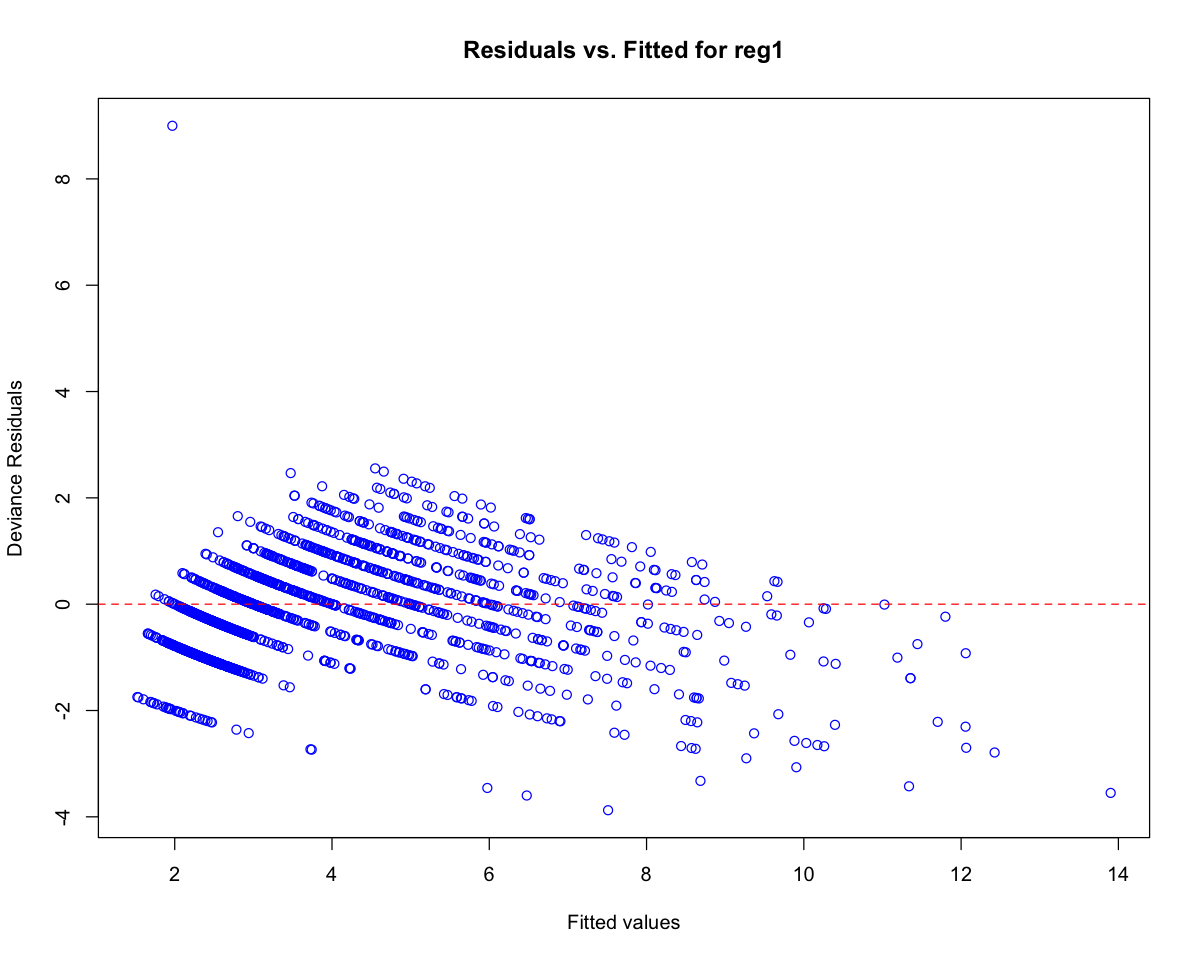

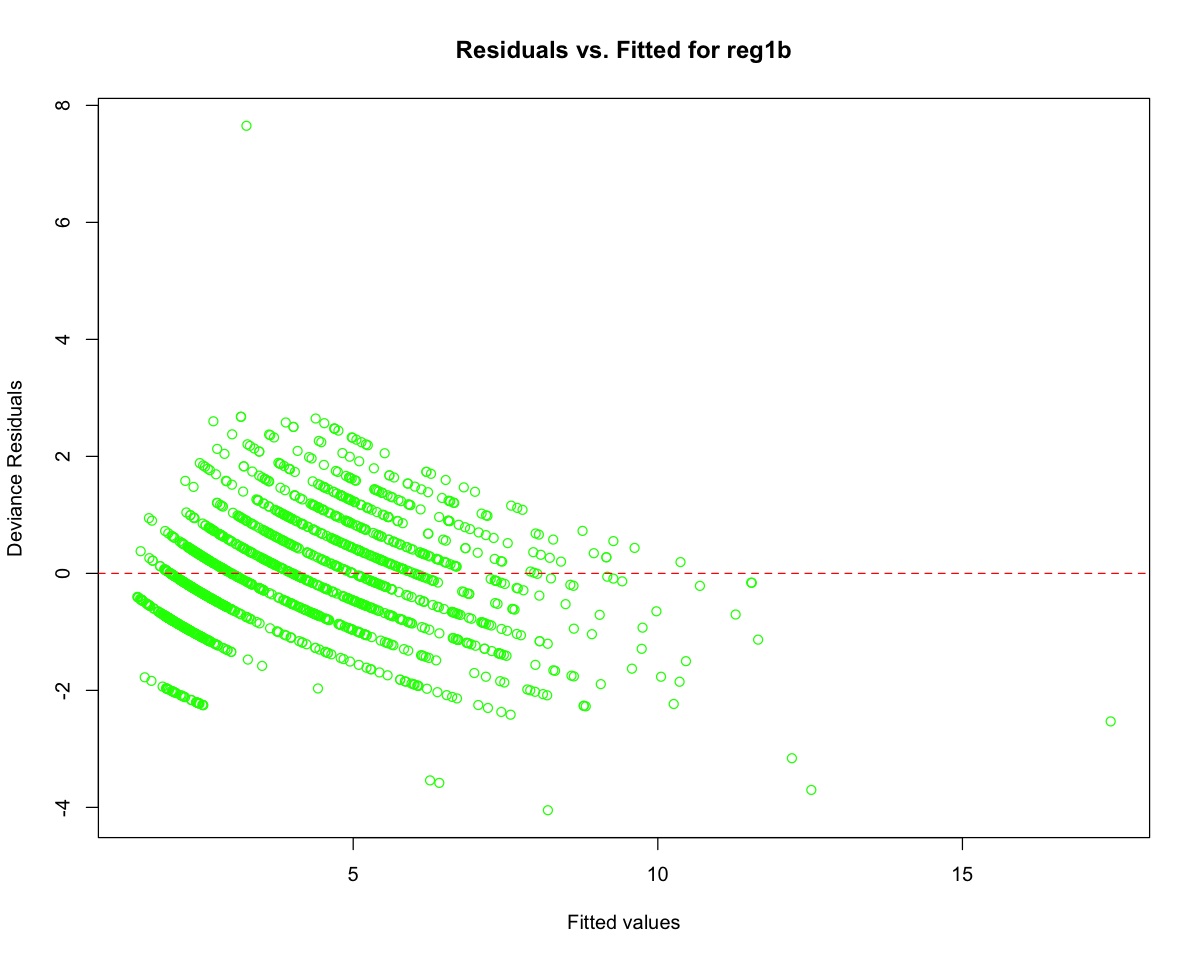

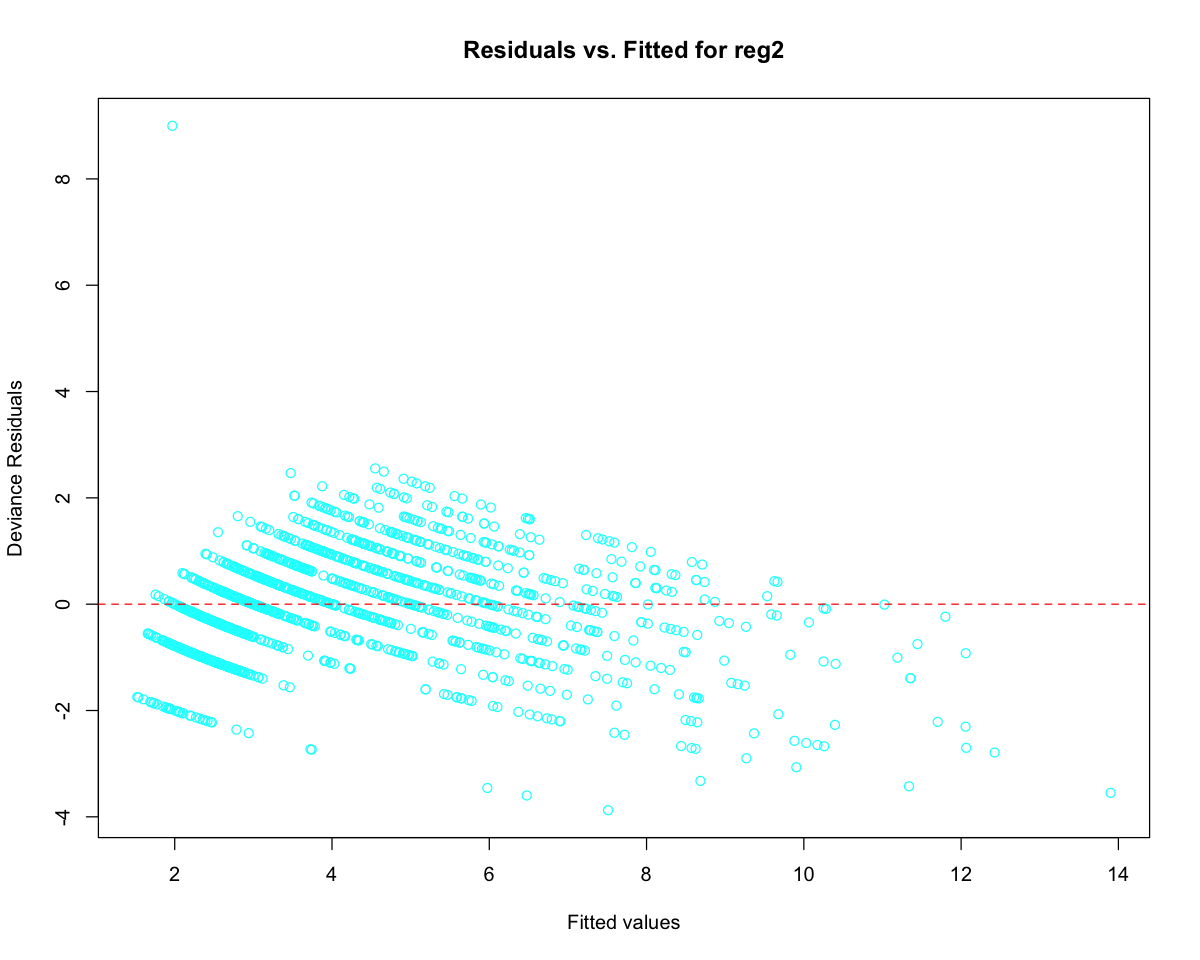

In [17]:
par(mfrow = c(1, 1))  # Reset plotting layout

# Residuals vs. Fitted for reg1
plot(fitted(reg1), residuals(reg1, type = "deviance"), 
	 main = "Residuals vs. Fitted for reg1", 
	 xlab = "Fitted values", ylab = "Deviance Residuals", col = "blue")
abline(h = 0, col = "red", lty = 2)

# Residuals vs. Fitted for reg1b
plot(fitted(reg1b), residuals(reg1b, type = "deviance"), 
	 main = "Residuals vs. Fitted for reg1b", 
	 xlab = "Fitted values", ylab = "Deviance Residuals", col = "green")
abline(h = 0, col = "red", lty = 2)

# Residuals vs. Fitted for reg2
plot(fitted_poisson_model$fitted.values, residuals(fitted_poisson_model, type = "deviance"), 
	 main = "Residuals vs. Fitted for reg2", 
	 xlab = "Fitted values", ylab = "Deviance Residuals", col = "cyan")
abline(h = 0, col = "red", lty = 2)

# Extract the fitted model from the workflow
fitted_poisson_model <- poisson_model |>
     extract_fit_parsnip() |>
     pluck("fit")

# Calculate robust covariance matrix
vcov_robust_poisson <- vcovHC(fitted_poisson_model, type = "HC")

# Calculate robust standard errors
robust_se_poisson <- sqrt(diag(vcov_robust_poisson))

robust_se_poisson

# Conduct hypothesis tests with robust standard errors
reg2 <- coeftest(fitted_poisson_model, vcov. = vcov_robust_poisson)

reg1 <- glm(
    NumWebPurchases ~ Income + MntGoldProds + NumCatalogPurchases + 
        NumStorePurchases + NumWebVisitsMonth + MntWines + MntFruits + 
        MntMeatProducts + MntFishProducts + MntSweetProducts, 
    data = market_data_train, 
    family = poisson(link = "log")
)
summary(reg1)



In 3 or 4 sentences give a brief interpretation of the results. If needed, comment on any unexpected result or potential problems with the analysis, and possible ways to address issues encountered. If results are as expected, explain how they address the question of interest. **Do not exceed the 4 sentences limit**.

